In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import air_traffic.io as air_io
import air_traffic.loop as air_lp

In [17]:
datadir = "../data/cleaned"
savedir = "../data/results"

reprocess = False  # Whether to re-compute everything

This notebook concerns flight rescheduling strategy --- when the airport is too busy, can we reduce the waiting time of flights by rescheduling some of them to arrive later?

This study involves quite a lot of definitions. I invite you to read Section 4.2.2 and 4.2.3 of my [thesis](https://drive.google.com/file/d/1wgr3l9psxnW8qiUr-FL-vXN2wRbjcxAC/view?usp=sharing) for the details. 

In [18]:
if reprocess:
    dataset = air_io.read_trajectories_range(datadir, "2017-01-01", "2017-01-31")
    air_io.loop_write(dataset, f"{savedir}/loops_201701.csv")

loop_data = air_io.loop_read_area(f"{savedir}/loops_201701.csv")

## 1 - Statistics of Holding Patterns

When the airport is busy, incoming flights would need to wait for landing. These waiting flights would fly in loops, formally referred to as "holding patterns" while they are waiting (because they cannot just stop moving in the air). These holding patterns would take place in three specific holding areas around the airport. Studying these holding patterns is useful for determining whether rescheduling is helpful. But first, we need to confirm that the holding patterns are similar in the three holding areas before continuing.

In [19]:
# --------------------------------------------------------------------------- #
def loop_length(data):

    length = []
    for x in data:
        x = np.array(x, dtype=float)
        diff = (x[1:] - x[:-1]) / 60  # in unit of minutes
        length.extend(diff)

    return length

# --------------------------------------------------------------------------- #

areas = ["ABBEY", "BETTY", "CANTO"]
loop_stat = {a: {} for a in areas}


for a in areas:
    loop_data_this = loop_data[a]

    loop_stat[a]["length"] = loop_length(loop_data_this)
    loop_stat[a]["count"] = [len(x) - 1 for x in loop_data_this]

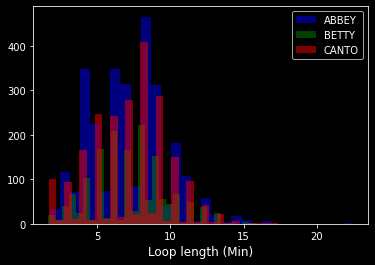

In [30]:
fig, ax = plt.subplots()

colors = ["blue", "green", "red"]

for i, a in enumerate(areas):
    ax.hist(loop_stat[a]["length"], bins=30, color=colors[i], 
            density=False, alpha=0.5, label=a)
    
ax.set_xlabel("Loop length (Min)", fontsize=12)
ax.legend(loc="upper right")

plt.show()

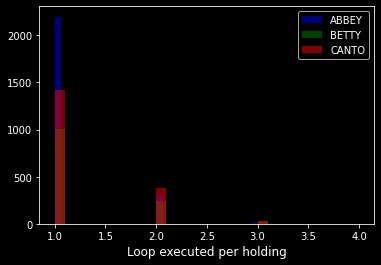

In [31]:
fig, ax = plt.subplots()

colors = ["blue", "green", "red"]

for i, a in enumerate(areas):
    ax.hist(loop_stat[a]["count"], bins=30, color=colors[i], 
            density=False, alpha=0.5, label=a)
    
ax.set_xlabel("Loops executed per holding", fontsize=12)
ax.legend(loc="upper right")

plt.show()

## Rescheduling Analysis

Here I basically just reproduce Fig.4.4 and 4.5 of my thesis, but using only one month of data. The conclusion is the same, flight rescheduling can offer substantial benefit when being done optimally.

In [24]:
# Prepare data for the rescheduling study
loop_data = air_io.loop_read(f"{savedir}/loops_201701.csv", keep_area=False)

# Sort the flights by their exit time
loop_exit = np.array([float(x[-1]) for x in loop_data])
ind_sort = np.argsort(loop_exit)
loop_exit = loop_exit[ind_sort]

# Now build the sorted loop point sequences
loop_min = []
for i in ind_sort:
    loop_min.append(np.array(loop_data[i][:-1], dtype=float))

In [25]:
rs_stat = {"xi": [], "s": [], "s1": []}

for i in range(len(loop_min)):

    # Divide by 60 to convert to minutes
    time_saved = air_lp.reschedule_flight(loop_min, loop_exit, i, tol=30) / 60 

    rs_stat["xi"].append(len(time_saved) - 1)
    rs_stat["s"].append(np.sum(time_saved))
    rs_stat["s1"].append(time_saved[0])


# Save the results
for k in rs_stat:
    np.savetxt(f"{savedir}/rescheduling_{k}.txt", rs_stat[k])

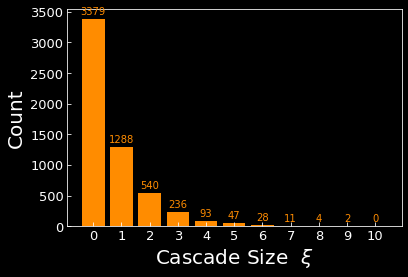

In [32]:
fig, ax = plt.subplots()

edges = np.arange(-0.5, 11, 1)
centers = (edges[:-1] + edges[1:]) / 2
hist, _ = np.histogram(rs_stat["xi"], bins=edges)

ax.tick_params(which="both", direction="in")
ax.tick_params(which="major", length=4, labelsize=13)

ax.bar(centers, hist, color="darkorange")
ax.set_xticks(centers)

for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(f'{int(height)}', xy=(rect.get_x()+rect.get_width()/2, height),
                xytext=(0, 2.5), textcoords='offset points',
                ha='center', va='bottom', fontsize=10, color="darkorange")

ax.set_xlabel(r"Cascade Size $\ \xi$", fontsize=20)
ax.set_ylabel("Count", fontsize=20)

plt.show()

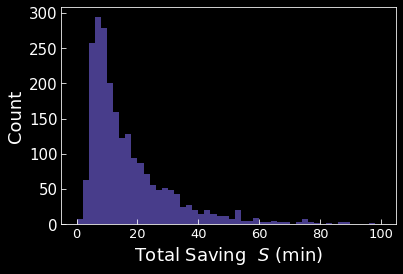

In [35]:
fig, ax = plt.subplots()

# Extract the population with nonzero saving
rs_stat["s"] = np.array(rs_stat["s"])[np.nonzero(rs_stat["s"])]

bins = np.arange(0, 101, 2)
ax.hist(rs_stat["s"], bins=bins, color="darkslateblue", alpha=1.0)

ax.set_xlabel("Total Saving $\ S$ (min)", fontsize=18)
ax.set_ylabel("Count", fontsize=18)

ax.tick_params(which="both", direction="in")
ax.tick_params(which="major", length=5, labelsize=15)
ax.tick_params(axis="x", labelsize=13)

plt.show()

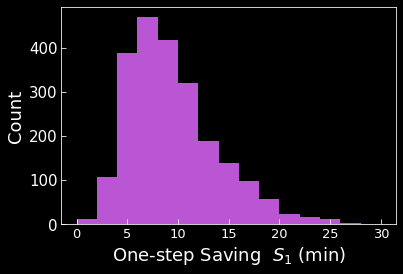

In [34]:
fig, ax = plt.subplots()

# Extract the population with nonzero saving
rs_stat["s1"] = np.array(rs_stat["s1"])[np.nonzero(rs_stat["s1"])]

bins = np.arange(0, 31, 2)
ax.hist(rs_stat["s1"], bins=bins, color="mediumorchid", alpha=1.0)

ax.set_xlabel("One-step Saving $\ S_1$ (min)", fontsize=18)
ax.set_ylabel("Count", fontsize=18)

ax.tick_params(which="both", direction="in")
ax.tick_params(which="major", length=5, labelsize=15)
ax.tick_params(axis="x", labelsize=13)

plt.show()